# TCGA Head and Neck Cancer Example analysis

DNA methytion predicted proteins, tissue type, and cancer progression

Paul Yousefi  
2025-03-10

# Load cleaned TCGA clinical and predicted protein level data

In [ ]:
options(repos = c(CRAN = "https://cran.rstudio.com"))

if (!requireNamespace("ggplot2", quietly = TRUE)) {
  install.packages("ggrepel")
}
library(ggplot2)
if (!requireNamespace("ggrepel", quietly = TRUE)) {
  install.packages("ggrepel")
}
library(ggrepel)
library(ggplot2)
if (!requireNamespace("here", quietly = TRUE)) {
  install.packages("here")
}
library(here)

here() starts at /Users/nq23569/Downloads

Installing package into '/opt/homebrew/lib/R/4.4/site-library'
(as 'lib' is unspecified)

also installing the dependencies 'systemfonts', 'textshaping', 'gert', 'ragg', 'usethis', 'pkgdown'

Warning in install.packages("devtools"): installation of package 'systemfonts'
had non-zero exit status

Warning in install.packages("devtools"): installation of package 'gert' had
non-zero exit status

Warning in install.packages("devtools"): installation of package 'textshaping'
had non-zero exit status

Warning in install.packages("devtools"): installation of package 'usethis' had
non-zero exit status

Warning in install.packages("devtools"): installation of package 'ragg' had
non-zero exit status

Warning in install.packages("devtools"): installation of package 'pkgdown' had
non-zero exit status

Warning in install.packages("devtools"): installation of package 'devtools' had
non-zero exit status

Installing 2 packages: impute, RPMM

Installing packages into '/opt/homebrew/lib/R/4.4/site-library'
(as 'lib' is unspecified)

Installing package into '/opt/homebrew/lib/R/4.4/site-library'
(as 'lib' is unspecified)

Loading required package: RPMM

Loading required package: cluster

Loading required package: impute

In [ ]:
#combined.filename <- file.path(resultsdir, "combined-clin-pred-proteins.txt")
combined.filename <- file.path("combined-clin-pred-proteins.txt")
data <- read.table(combined.filename,
  header = T, sep = "\t", stringsAsFactors = F
)

In [ ]:
protein.names <-
  subset(
    meffonym::meffonym.models(full = T),
    grepl("^episcores", filename)
  )$name
protein.names <- make.names(protein.names)

table(protein.names %in% colnames(data))

## Run glms for association between proteins levels and tissue type (tumor vs. normal)

In [ ]:
## define glm formulae with pred.proteins as predictors of 'tumor.or.normal'
## tissue i.e. tumor.or.normal ~ pred.protein
formulae <- sapply(protein.names, function(i) {
  reformulate(i, response = "tumor")
}, simplify = F)

# run glms
fit <- sapply(formulae, function(i) {
  glm(i, data = data, family = binomial())
}, simplify = F)

fit.summary <- sapply(fit, function(i) {
  out <- summary(i)$coefficients
  out[, "Estimate"] <- out[, "Estimate"]
  out
}, simplify = F)

fit.coefs <- sapply(fit.summary, function(i) {
  i[2, c("Estimate", "Pr(>|z|)")]
}, simplify = F)
fit.coefs <- {
  x <- do.call(rbind, fit.coefs)
  data.frame(
    pred.protein = rownames(x),
    coef = x[, "Estimate"],
    p.value = x[, "Pr(>|z|)"]
  )
}

bonferroni <- -log10(0.05 / length(fit))

### Visualize results

increasing max.overlaps

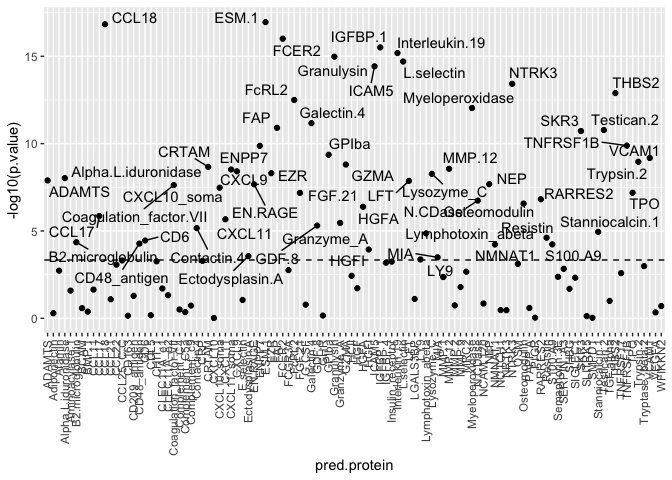

increasing max.overlaps

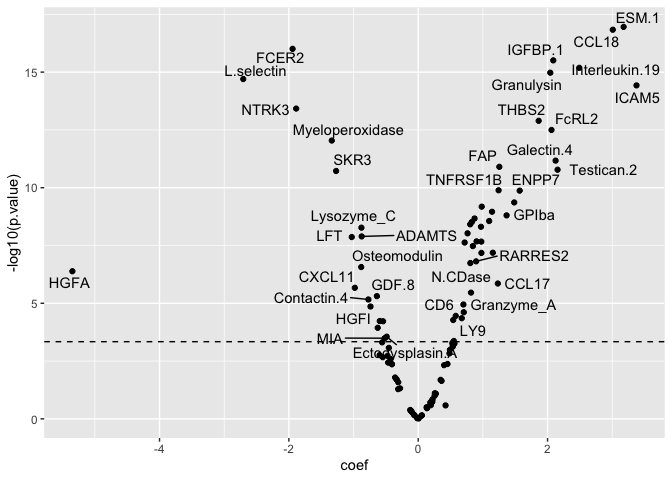

In [ ]:
fit.coefs |>
  ggplot(aes(x = pred.protein, y = -log10(p.value))) +
  geom_point() +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) +
  geom_text_repel(
    data = fit.coefs[which((-log10(fit.coefs$p.value) > bonferroni)), ],
    aes(x = pred.protein, y = -log10(p.value), label = pred.protein)
  ) +
  geom_hline(
    yintercept = bonferroni,
    linetype = "dashed"
  )

## Run glms for association between proteins levels and progression free interval (PFI)

This analysis should be restricted to measurements taken from tumor
samples

In [ ]:
tumor.data <- subset(data, tumor == 1)

## define glm formulae with pred.proteins as predictors of pfi
## tissue i.e. pfi ~ pred.protein
formulae <- sapply(protein.names, function(i) {
  reformulate(i, response = "pfi")
}, simplify = F)

# run glms
fit <- sapply(formulae, function(i) {
  glm(i, data = tumor.data, family = binomial())
}, simplify = F)

fit.summary <- sapply(fit, function(i) {
  out <- summary(i)$coefficients
  out[, "Estimate"] <- out[, "Estimate"]
  out
}, simplify = F)

fit.coefs <- sapply(fit.summary, function(i) {
  i[2, c("Estimate", "Pr(>|z|)")]
}, simplify = F)
fit.coefs <- {
  x <- do.call(rbind, fit.coefs)
  data.frame(
    pred.protein = rownames(x),
    coef = x[, "Estimate"],
    p.value = x[, "Pr(>|z|)"]
  )
}

### Visualize results

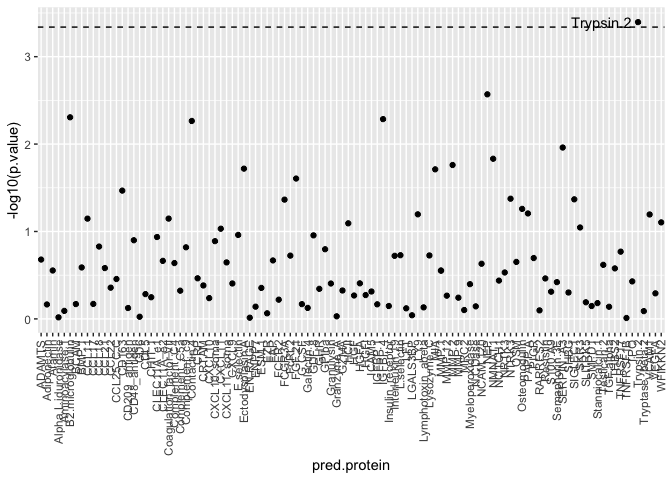

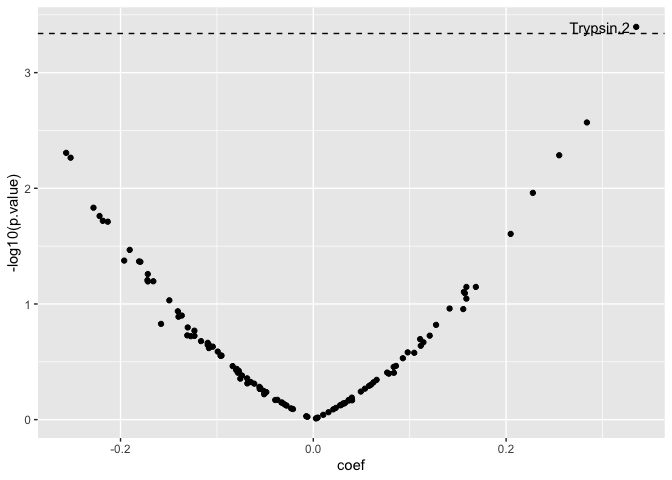

In [ ]:
fit.coefs |>
  ggplot(aes(x = pred.protein, y = -log10(p.value))) +
  geom_point() +
  theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust = 1)) +
  geom_text_repel(
    data = fit.coefs[which((-log10(fit.coefs$p.value) > bonferroni)), ],
    aes(x = pred.protein, y = -log10(p.value), label = pred.protein)
  ) +
  geom_hline(
    yintercept = bonferroni,
    linetype = "dashed"
  )